In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np  

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from data.data_loaders import get_data, load_curtains_pd
from utils.DRE import get_auc
from utils.io import get_top_dir, register_experiment
from utils.plotting import plot_rates_dict, hist_features
from utils.torch_utils import shuffle_tensor


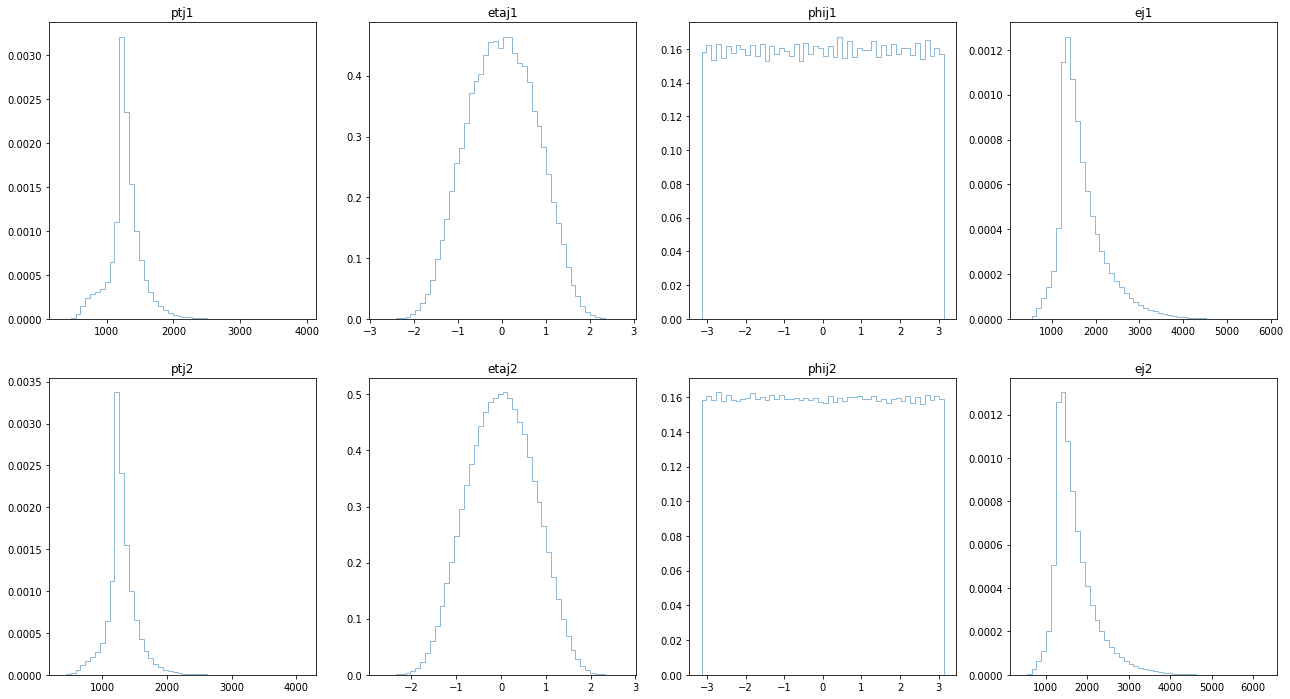

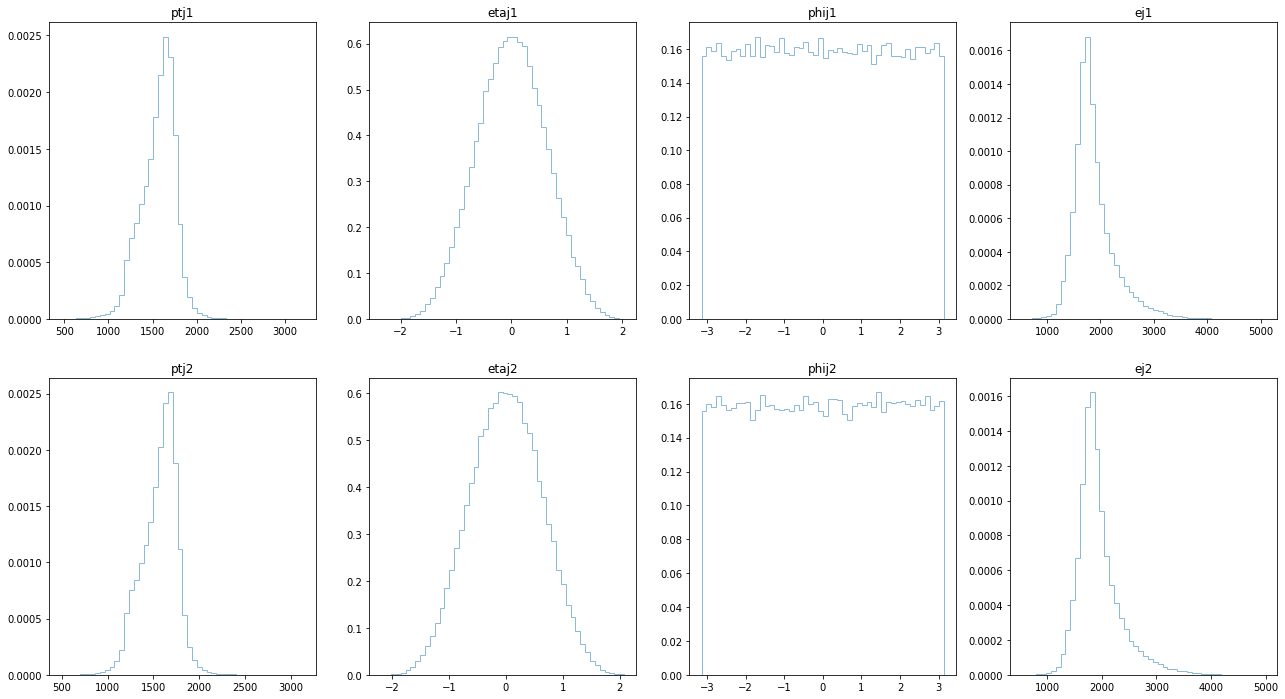

In [27]:
sm = load_curtains_pd(feature_type=10)
ad = load_curtains_pd(sm='WZ_allhad_pT', feature_type=10)

In [28]:
sm = sm.dropna()
ad = ad.dropna()

In [8]:
train_set_x = np.concatenate([sm.values,ad[:1000].values])
train_set_y = np.concatenate([np.zeros(len(sm)),np.ones(1000)])

In [9]:
window = (3300,3700)
inw = (train_set_x[:,-1] >= window[0]) & (train_set_x[:,-1] < window[1])

In [10]:
train_set_x = train_set_x[inw]
train_set_y = train_set_y[inw]

In [11]:
len(train_set_x),len(train_set_y)

(122105, 122105)

In [16]:
SEED = 123
np.random.seed(42+SEED)

In [17]:
idx = np.arange(0,len(train_set_x),1)
np.random.shuffle(idx)

In [18]:
train_set_x = train_set_x[idx]
train_set_y = train_set_y[idx]

In [21]:
nfold = 5
fold = np.arange(0,len(train_set_x),nfold)
folds = [fold+i for i in range(nfold)]

In [22]:
folds

[array([     0,      5,     10, ..., 122090, 122095, 122100]),
 array([     1,      6,     11, ..., 122091, 122096, 122101]),
 array([     2,      7,     12, ..., 122092, 122097, 122102]),
 array([     3,      8,     13, ..., 122093, 122098, 122103]),
 array([     4,      9,     14, ..., 122094, 122099, 122104])]

In [32]:
import sklearn.preprocessing as skpp

In [30]:
scaler = skpp.RobustScaler()

In [34]:
scaler.fit(train_set_x)

RobustScaler()

In [35]:
train_set_xt = scaler.transform(train_set_x)

In [48]:
# for fold in range(nfold):
fold = 0
train_idx = np.concatenate([folds[j+i] for j in range(nfold-2)])
val_idx = folds[i+3 % nfold]
test_idx = folds[i+4 % nfold]
X_train_t = train_set_xt[train_idx,:-1]
Y_train   = train_set_y[train_idx]
X_val_t   = train_set_xt[val_idx,:-1]
Y_val     = train_set_y[val_idx]
X_test_t  = train_set_xt[test_idx,:-1]
Y_test    = train_set_y[test_idx]

W_train   = np.ones_like(Y_train,dtype=np.float)
W_val   = np.ones_like(Y_val,dtype=np.float)
W_test   = np.ones_like(Y_test,dtype=np.float)

In [43]:
len(Y_train),len(Y_val),len(Y_test)

(73263, 24421, 24421)

In [49]:
from models.classifier import Classifier
import torch.nn as nn

In [46]:
from torch.optim import Adam

In [58]:
from sklearn.metrics import roc_curve

In [52]:
from models.nn.networks import dense_net
def get_net(batch_norm=False, layer_norm=False, width=32, depth=2, dropout=0.0):
    def net_maker(nfeatures, nclasses):
        return dense_net(nfeatures, nclasses, layers=[width] * depth, batch_norm=batch_norm, layer_norm=layer_norm,
                         drp=dropout, context_features=None)

    return net_maker

net = get_net(False,False,32,4)

classifier = Classifier(net,train_set_xt.shape[1]-1, 1, "test",activation=nn.ReLU())


In [77]:
train_data = (torch.Tensor(X_train_t),torch.Tensor(Y_train).reshape(-1,1),torch.Tensor(W_train).reshape(-1,1))
valid_data = (torch.Tensor(X_val_t),torch.Tensor(Y_val).reshape(-1,1),torch.Tensor(W_val).reshape(-1,1))
optimizer = Adam(lr=1e-4,params=classifier.parameters())
batch_size = 128
n_epochs = 100

In [62]:
n_train = len(Y_train)
n_valid = len(Y_val)
n_batch = n_train // batch_size

In [79]:
train_loss = np.zeros(n_epochs)
valid_loss = np.zeros(n_epochs)
max_sic_tpr = np.zeros(n_epochs)
max_sic = np.zeros(n_epochs)
# scheduler_bool = scheduler is not None
# classifier_dir = os.path.join(sv_dir, f'classifier_{fold}')
# os.makedirs(classifier_dir, exist_ok=True)
for epoch in range(n_epochs):  # loop over the dataset multiple times
# Start the timer
    batch_idx = np.arange(0,n_train,1)
    np.random.shuffle(batch_idx)
    batch_idx = batch_idx[:n_batch*batch_size]
    batch_idx = batch_idx.reshape(-1,batch_size)
    running_loss = np.zeros(n_train)
    for i, id in enumerate(batch_idx):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Get the model loss
        data = [train_data[k][id].to(device) for k in range(3)]
        loss = classifier.compute_loss(data)
        # Propogate the loss
        loss.backward()
        # Update the parameters
        optimizer.step()
        # if scheduler_bool:
        #     scheduler.step()

        # Get statistics
        running_loss[i] = loss.item()

    # Save loss info for the epoch
    train_loss[epoch] = np.mean(running_loss)

    # Validate
    running_loss = np.zeros(n_valid)
    classifier.eval()
    store = []
    with torch.no_grad():
        for i, data in enumerate(valid_data, 0):
            # Get the model loss
            loss, pred = classifier.compute_loss(data, return_pred=True)
            running_loss[i] = loss.item()
            store += [np.concatenate([data[1].cpu(), pred.cpu()], 1)]
    lbls = np.concatenate(store)
    fpr, tpr, _ = roc_curve(lbls[:, 0], lbls[:, 1])
    fpr_mx = fpr != 0
    sic = tpr[fpr_mx] / fpr[fpr_mx] ** 0.5
    max_ind = np.argmax(sic)
    max_sic[epoch] = sic[max_ind]
    max_sic_tpr[epoch] = tpr[fpr_mx][max_ind]
    valid_loss[epoch] = np.mean(running_loss)
# classifier.save(f'{classifier_dir}/{epoch}')

# Stop the timer
# classifier.train()

KeyboardInterrupt: 

In [ ]:
# class Classifier(nn.Module):
#     def __init__(self,ninputs,nodes,classes):
#         super(Classifier,self).__init__()
#         ins = [ninputs]+nodes
#         classes = 2 if classes == 1 else classes
#         outs = nodes+[classes]
#         self.layers = nn.ModuleList([nn.Linear(i,o) for i,o in zip(ins,outs)])
#         # self.layers = [nn.Linear(i,o) for i,o in zip(ins,outs)]
#         self.acts =  nn.ModuleList([nn.ReLU() for i in ins] + [nn.Softmax()])
#         # self.myparameters = nn.ParameterList(self.layers)
    
#     def forward(self,x):
#         for l,a in zip(self.layers,self.acts):
#             x = a(l(x))
#         return x

In [ ]:
X_train.shape[1]

8

In [ ]:
batch_size = 128
layers = [64,64,64]
learning_rate = 1e-3
nepochs = 100

In [89]:
myclass = Classifier(ninputs=X_train.shape[1],nodes=layers,classes=2)

In [90]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(myclass.parameters(),lr=learning_rate)

In [62]:
train_loss = np.zeros(nepochs)
valid_loss = np.zeros(nepochs)

n_train = len(Xw_train_t)
n_val = len(Xw_val_t)


In [66]:
n_train,batch_size,n_train//batch_size

(40656, 128, 317)

In [91]:
nbatch = n_train//batch_size
for epoch in range(nepochs):
    print(f"Epoch {epoch}/{nepochs}")
    idx = np.arange(0,n_train,1)
    np.random.shuffle(idx)
    # opt.zero_grad()
    rolling_loss = []
    for i,batch in enumerate(range(nbatch)):
        opt.zero_grad()
        # if (i % 10) == 0:
        #     print(f"Batch {i}/{nbatch}")
        X = Xw_train_t[idx[batch*batch_size:(batch+1)*batch_size]]
        Y = Yw_train[idx[batch*batch_size:(batch+1)*batch_size]]
        Yp = myclass(X)
        l = loss(Yp,Y)
        rolling_loss.append(l.item())
        l.backward()
        opt.step()
        if (i % 10) == 0:
            print(f"Batch {i}/{nbatch}, rolling loss = {rolling_loss[-1]}")
            print(X)
            print(Y)
            print(Yp)

    train_loss.append(np.mean(running_loss))
    with torch.no_grad():
        Ywp = myclass(Xw_val_t)
        val_l = loss(Ywp,Yw_val).item()
        val_loss.append(val_l)
    print(f"Epoch Loss: {train_loss[-1]}\tVal loss: {val_loss[-1]}")

Epoch 0/100
Batch 0/317, rolling loss = 0.6909292340278625
tensor([[ 0.5779, -1.0843, -1.8276,  ..., -0.2294,  0.1443,  0.9084],
        [ 0.8535, -1.0197, -0.1164,  ...,  0.1625, -2.2824,  0.5533],
        [ 0.0458, -0.2334,  0.3790,  ...,  0.4117,  0.7466,  1.1634],
        ...,
        [-0.1914, -0.2875,  0.1300,  ...,  0.0031, -0.8299, -0.6416],
        [-0.3921,  0.0797,  0.6444,  ...,  0.5030,  0.9703, -0.6448],
        [-0.3583,  0.3487, -0.5294,  ..., -1.7574, -0.4717, -0.0882]])
tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0])
tensor([[0.0841, 0.0433],
        [0.1404, 0.0000],
        [0.0490, 0.036

KeyboardInterrupt: 